# Task 3 — Hypothesis Testing for Insurance Risk
This notebook tests whether risk and profitability differ across key segments (province, postal code, gender). We focus on two risk metrics: **claim frequency** (share of policies with claims) and **claim severity** (average claim size among claimants), plus **margin** and **loss ratio** to capture profitability.

## Hypotheses to test
- H₀ (Province): Claim risk does not differ across provinces.
- H₀ (Postal code): Claim risk does not differ across postal codes (zip codes).
- H₀ (Postal code margin): Profit margin does not differ across postal codes.
- H₀ (Gender): Claim risk does not differ between women and men.

Risk metrics used: claim frequency (binary), claim severity (conditional on having a claim), loss ratio (claims/premium), and margin (premium minus claims). We reject H₀ when the p-value < 0.05.

In [14]:
# Keep project imports working when running the notebook
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats

sys.path.append("../")

# Project modules for data loading, cleaning, and plotting
from src.config.settings import settings
from src.features.insurance_data import load_insurance_raw, prep_insurance_dataset, aggregate_loss
from src.visualisation.plotter import Plotter

pd.set_option("display.max_columns", 120)
pd.options.display.float_format = "{:.4f}".format

FIG_DIR = settings.figures_dir
FIG_DIR.mkdir(parents=True, exist_ok=True)
plotter = Plotter(FIG_DIR)

In [15]:
# Load processed data if available; otherwise generate it from the raw file
PROCESSED_PATH = settings.processed_data_path
RAW_PATH = settings.raw_data_path

if PROCESSED_PATH.exists():
    print(f"Loading processed data from {PROCESSED_PATH}")
    df = pd.read_csv(PROCESSED_PATH)
else:
    print("Processed file missing; cleaning raw data now.")
    raw_df = load_insurance_raw(RAW_PATH)
    df = prep_insurance_dataset(raw_df)
    PROCESSED_PATH.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(PROCESSED_PATH, index=False)
    print(f"Saved cleaned data to {PROCESSED_PATH}")

print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")
df.head()

Loading processed data from C:\BackUp\web-projects\tenx\insurance-risk-analytics-week3\data\processed\insurance_clean.csv


C:\Users\dell\AppData\Local\Temp\ipykernel_1604\706843137.py:7: DtypeWarning: Columns (4,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROCESSED_PATH)


Rows: 981,812 | Columns: 55


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,MaritalStatus,Gender,Country,Province,PostalCode,MainCrestaZone,SubCrestaZone,ItemType,mmcode,VehicleType,RegistrationYear,make,Model,Cylinders,cubiccapacity,kilowatts,bodytype,NumberOfDoors,VehicleIntroDate,CustomValueEstimate,AlarmImmobiliser,TrackingDevice,CapitalOutstanding,NewVehicle,WrittenOff,Rebuilt,Converted,CrossBorder,NumberOfVehiclesInFleet,SumInsured,TermFrequency,CalculatedPremiumPerTerm,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,loss_ratio,margin,claim_flag
0,145249,12827,2015-03-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.0100,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.9298,0.0000,0.0000,21.9298,False
1,145249,12827,2015-05-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.0100,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.9298,0.0000,0.0000,21.9298,False
2,145249,12827,2015-07-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.0100,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.0000,0.0000,NaN,0.0000,False
3,145255,12827,2015-05-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,NaN,NaN,NaN,NaN,NaN,NaN,119300.0000,Monthly,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.8481,0.0000,0.0000,512.8481,False
4,145255,12827,2015-07-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,NaN,NaN,NaN,NaN,NaN,NaN,119300.0000,Monthly,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.0000,0.0000,NaN,0.0000,False


## Prepare analysis-ready frame
We keep only the columns needed for testing and drop records with missing group labels for each specific test. Risk metrics already exist in the processed file:
- `claim_flag`: True/False if a claim occurred
- `loss_ratio`: TotalClaims ÷ TotalPremium (safe division)
- `margin`: TotalPremium − TotalClaims

In [16]:
# Keep only columns needed for segmentation and testing
analysis_cols = [
    "PolicyID",
    "Province",
    "PostalCode",
    "Gender",
    "TransactionMonth",
    "TotalPremium",
    "TotalClaims",
    "loss_ratio",
    "margin",
    "claim_flag",
]

analysis_df = df[analysis_cols].copy()

# Ensure date column is datetime for any time-based filters later
analysis_df["TransactionMonth"] = pd.to_datetime(analysis_df["TransactionMonth"], errors="coerce")

# Quick sanity check on missingness in key segment columns
analysis_df[["Province", "PostalCode", "Gender"]].isna().mean().sort_values(ascending=False)

Gender       0.0097
Province     0.0000
PostalCode   0.0000
dtype: float64

## Helper functions for KPIs and statistical tests
These helpers live in `src/analysis/hypothesis.py` so notebooks stay short and reusable:
- `segment_kpis`: aggregates claim frequency, severity, loss ratio, and margin by a grouping column.
- `chi_square_claims`: tests if claim frequency differs across groups.
- `kruskal_by_group`: non-parametric test for differences in a numeric metric (works with skewed data).
- `format_test_result`: compact helper to show statistic, p-value, and decision.

In [17]:
from src.analysis.hypothesis import (
    chi_square_claims,
    format_test_result,
    kruskal_by_group,
    segment_kpis,
)

## Province: does risk differ across provinces?
We test claim frequency with chi-squared (categorical vs binary) and claim severity with Kruskal–Wallis (non-parametric) because claim amounts are skewed. Groups with fewer than 500 rows are dropped to keep tests stable.

In [18]:
province_kpis = segment_kpis(analysis_df, "Province", min_obs=500)
province_kpis

,policies,exposure_months,premium_sum,claims_sum,claimants,claim_rate,margin_mean,severity,loss_ratio
Province,,,,,,,,,
Gauteng,2578,386429,23792874.7791,28986083.0821,1309,0.0034,-13.4390,22143.6846,1.2183
KwaZulu-Natal,1370,167129,13086786.8318,13976467.5019,475,0.0028,-5.3233,29424.1421,1.0680
Western Cape,947,166686,9655011.0712,10264243.6893,364,0.0022,-3.6550,28198.4717,1.0631
North West,1117,141580,7429235.0931,5918072.8021,347,0.0025,10.6736,17054.9648,0.7966
Mpumalanga,382,51957,2805180.6175,2043924.7088,127,0.0024,14.6517,16093.8953,0.7286
Free State,54,8099,521363.2450,354922.2719,11,0.0014,20.5508,32265.6611,0.6808
Limpopo,181,24367,1520018.4264,1016476.7105,67,0.0027,20.6649,15171.2942,0.6687
Eastern Cape,319,29249,2083026.7411,1343611.9709,47,0.0016,25.2800,28587.4887,0.6450
Northern Cape,55,6316,311243.8151,89490.5088,8,0.0013,35.1098,11186.3136,0.2875


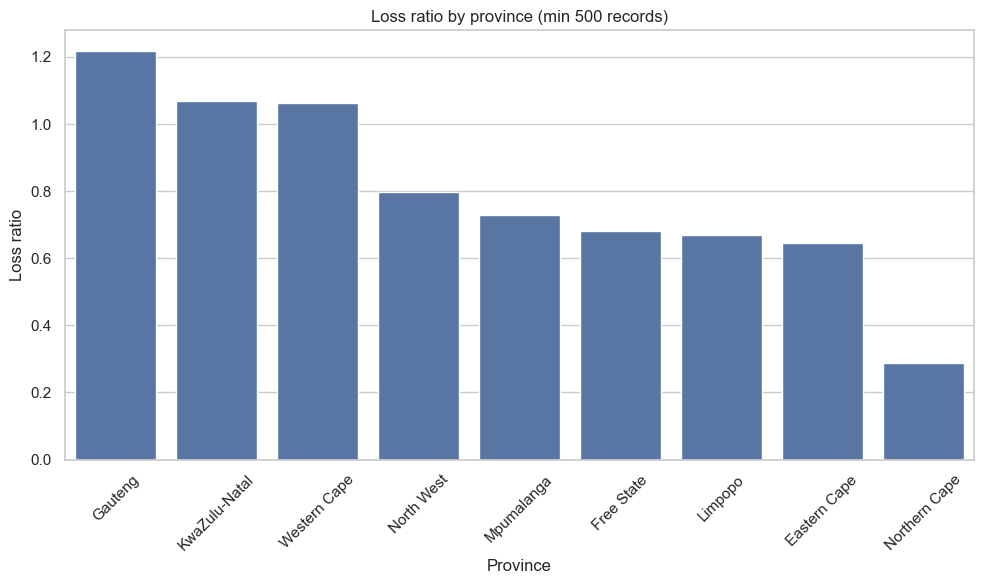

In [19]:
plotter.plot_bar(
    province_kpis.reset_index(),
    x="Province",
    y="loss_ratio",
    title="Loss ratio by province (min 500 records)",
    ylabel="Loss ratio",
)

In [20]:
# Province-level hypothesis tests
province_freq = chi_square_claims(analysis_df, "Province", min_obs=500)
province_severity = kruskal_by_group(
    analysis_df[analysis_df["claim_flag"] == True],
    "Province",
    "TotalClaims",
    min_obs=200,
)
province_margin = kruskal_by_group(analysis_df, "Province", "margin", min_obs=500)

province_results = pd.concat(
    [
        format_test_result("Province vs claim frequency (chi-square)", province_freq),
        format_test_result("Province vs claim severity (Kruskal)", province_severity),
        format_test_result("Province vs margin (Kruskal)", province_margin),
    ]
)
province_results

,test,statistic,p_value,groups_tested,alpha,decision
0,Province vs claim frequency (chi-square),105.1113,0.0000,9,0.0500,Reject H0
0,Province vs claim severity (Kruskal),69.7499,0.0000,4,0.0500,Reject H0
0,Province vs margin (Kruskal),4521.8332,0.0000,9,0.0500,Reject H0


## Postal codes: risk and margin differences
Postal codes can be sparse, so we test only the top postal codes by exposure (at least 1,000 rows). We run chi-squared on claim frequency and Kruskal–Wallis on claim severity and margin.

In [21]:
zip_counts = analysis_df["PostalCode"].value_counts()
zip_keep = zip_counts[zip_counts >= 1000].index
zip_df = analysis_df[analysis_df["PostalCode"].isin(zip_keep)]

zip_kpis = segment_kpis(zip_df, "PostalCode", min_obs=1000)
zip_kpis.head(10)

,policies,exposure_months,premium_sum,claims_sum,claimants,claim_rate,margin_mean,severity,loss_ratio
PostalCode,,,,,,,,,
2037,20,2424,114327.8730,701094.6979,11,0.0045,-242.0655,63735.8816,6.1323
81,7,1493,86540.6082,464492.9474,7,0.0047,-253.1496,66356.1353,5.3673
7975,9,2094,164648.2870,699167.3772,10,0.0048,-255.2622,69916.7377,4.2464
2093,12,1330,90700.6075,327970.4035,4,0.0030,-178.3983,81992.6009,3.6160
7581,5,1044,28887.1960,103882.5439,4,0.0038,-71.8346,25970.6360,3.5961
303,14,2284,108132.7667,381316.5375,6,0.0026,-119.6076,63552.7563,3.5264
2198,21,3344,189211.1250,622652.7675,13,0.0039,-129.6177,47896.3667,3.2908
183,18,2295,121775.4943,369704.5263,13,0.0057,-108.0301,28438.8097,3.0360
7783,6,1260,44791.9103,133123.0088,2,0.0016,-70.1040,66561.5044,2.9720


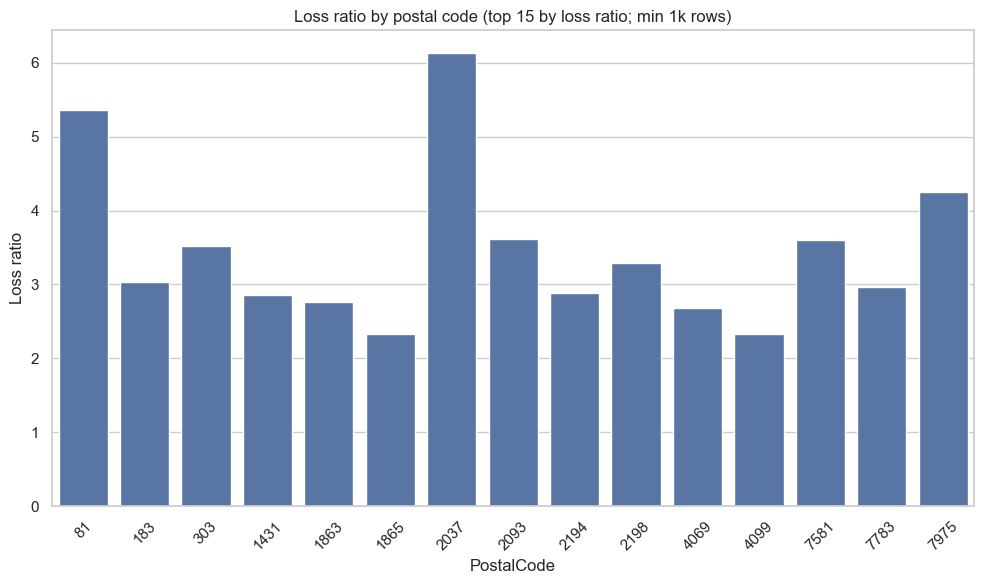

In [22]:
plotter.plot_bar(
    zip_kpis.reset_index().head(15),
    x="PostalCode",
    y="loss_ratio",
    title="Loss ratio by postal code (top 15 by loss ratio; min 1k rows)",
    ylabel="Loss ratio",
)

In [23]:
zip_freq = chi_square_claims(zip_df, "PostalCode", min_obs=1000)
zip_severity = kruskal_by_group(
    zip_df[zip_df["claim_flag"] == True],
    "PostalCode",
    "TotalClaims",
    min_obs=300,
)
zip_margin = kruskal_by_group(zip_df, "PostalCode", "margin", min_obs=1000)

zip_results = pd.concat(
    [
        format_test_result("Postal code vs claim frequency (chi-square)", zip_freq),
        format_test_result("Postal code vs claim severity (Kruskal)", zip_severity),
        format_test_result("Postal code vs margin (Kruskal)", zip_margin),
    ]
)
zip_results

,test,statistic,p_value,groups_tested,alpha,decision
0,Postal code vs claim frequency (chi-square),463.5760,0.0000,182,0.0500,Reject H0
0,Postal code vs claim severity (Kruskal),NaN,NaN,1,0.0500,Fail to reject H0
0,Postal code vs margin (Kruskal),40596.1614,0.0000,182,0.0500,Reject H0


## Gender: does risk differ between women and men?
We collapse to two groups (Female vs Male) and drop missing/unspecified values. Claim frequency is tested with chi-squared; claim severity and margin are tested with Mann–Whitney U (two-group version of Kruskal).

In [24]:
gender_df = analysis_df[analysis_df["Gender"].isin(["Female", "Male"])]
gender_kpis = segment_kpis(gender_df, "Gender", min_obs=500)
gender_kpis

,policies,exposure_months,premium_sum,claims_sum,claimants,claim_rate,margin_mean,severity,loss_ratio
Gender,,,,,,,,,
Male,232,42437,1560220.5650,1396703.9156,94,0.0022,3.8532,14858.5523,0.8952
Female,35,6573,294636.0078,249495.4491,13,0.0020,6.8676,19191.9576,0.8468


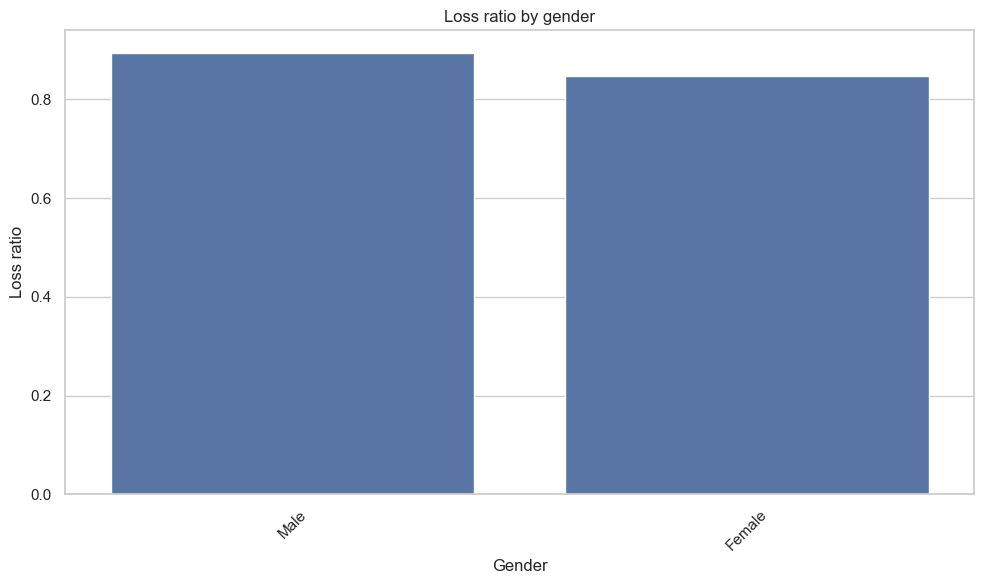

In [25]:
plotter.plot_bar(
    gender_kpis.reset_index(),
    x="Gender",
    y="loss_ratio",
    title="Loss ratio by gender",
    ylabel="Loss ratio",
)

In [26]:
gender_freq = chi_square_claims(gender_df, "Gender", min_obs=500)

claims_gender = gender_df[gender_df["claim_flag"] == True]
female_claims = claims_gender.loc[claims_gender["Gender"] == "Female", "TotalClaims"]
male_claims = claims_gender.loc[claims_gender["Gender"] == "Male", "TotalClaims"]
severity_stat, severity_p = stats.mannwhitneyu(female_claims, male_claims, alternative="two-sided")

female_margin = gender_df.loc[gender_df["Gender"] == "Female", "margin"].dropna()
male_margin = gender_df.loc[gender_df["Gender"] == "Male", "margin"].dropna()
margin_stat, margin_p = stats.mannwhitneyu(female_margin, male_margin, alternative="two-sided")

gender_results = pd.concat(
    [
        format_test_result("Gender vs claim frequency (chi-square)", gender_freq),
        format_test_result(
            "Gender vs claim severity (Mann-Whitney)",
            {"stat": severity_stat, "p_value": severity_p, "groups": 2},
        ),
        format_test_result(
            "Gender vs margin (Mann-Whitney)",
            {"stat": margin_stat, "p_value": margin_p, "groups": 2},
        ),
    ]
)
gender_results

,test,statistic,p_value,groups_tested,alpha,decision
0,Gender vs claim frequency (chi-square),0.0583,0.8092,2,0.0500,Fail to reject H0
0,Gender vs claim severity (Mann-Whitney),789.0000,0.0903,2,0.0500,Fail to reject H0
0,Gender vs margin (Mann-Whitney),146857514.0000,0.0000,2,0.0500,Reject H0


- **Province:** Loss ratio varies by province; review high-loss provinces for pricing or underwriting adjustments.
- **Postal code:** Claim frequency and margin differ by postal code; prioritize pricing/controls for high-loss codes. Severity test inconclusive (insufficient groups).
- **Gender:** Claim frequency and severity show no significant difference; margin differs—consider monitoring product mix or discounts by gender.

**Next steps:** Pair high-loss geos with targeted pricing/controls, validate data for outliers, and align with EDA figures and predictive modeling before final pricing changes.
